# Random stuff to look at in the ancillary file

In [1]:
%matplotlib ipympl
# from jupyterthemes import jtplot
# jtplot.style(theme='chesterish', ticks=True, grid=False, figsize=(6, 4.5))

In [2]:
pip install ephem

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pyglow

Note: you may need to restart the kernel to use updated packages.


In [14]:
# Common code for ICON users at Illinois. Geometrical transformations, airglow code, etc.

import numpy as np
from datetime import datetime, timedelta
from scipy import stats
import multiprocessing
from multiprocessing import Pool
import time
import math
from scipy import optimize
import ephem


def wgs84constants():
    '''
    Return the constants associated with the WGS-84 coordinate system
    
    OUTPUTS:
    
      * a - semi-major axis of Earth, km
      * b - semi-minor axis of Earth, km
      * e - eccentricity of Earth
      
    '''
    
    # http://en.wikipedia.org/wiki/World_Geodetic_System (Nov 10, 2014)
    # https://en.wikipedia.org/wiki/Flattening (Sep 9, 2015) 
    a = 6378.137 # semi-major axis of earth [km]
    inv_f = 298.257223563
    f = 1.0/inv_f
    b = a*(1-f) # semi-minor axis of earth [km]
    e = np.sqrt(1-b**2/a**2) # eccentricity of earth
    return a,b,e



def ecef_to_wgs84(ecef_xyz):
    '''
    Convert from earth-centered earth-fixed (ECEF)
    coordinates (x,y,z) to WGS-84 latitude, longitude, and altitude.
    INPUTS:
    
     *  ecef_xyz - a length-3 array containing the X, Y, and Z locations in ECEF
                   coordinates in kilometers.

    OUTPUTS:
     *  latlonalt - a length-3 array containing the WGS-84 coordinates:
                    [latitude (degrees), longitude (degrees), altitude (km)]
                    Altitude is defined as the height above the reference
                    ellipsoid. Longitude is defined in [0,360).

    HISTORY:
     * 11-Jun-2006: Initial MATLAB template created by Jonathan J. Makela
       (jmakela@uiuc.edu)
     * 17-July-2006: Algorithm implemented by Dwayne P. Hagerman
       (dhagerm2@uiuc.ed)
     * 10-Nov-2014: Translated to Python by Brian J. Harding
       (bhardin2@illinois.edu)
     * 19-Jan-2015: Changed from iterative to closed-form implementation (BJH)
     * 09-Sep-2015: Changed from ublox implementation (with mm accuracy) to
                    Olson implementation (with nm accuracy). (BJH)
                    https://possiblywrong.wordpress.com/2014/02/14/when-approximate-is-better-than-exact/
    '''
    
    
    # WGS-84 ellipsoid parameters
    a,b,_ = wgs84constants()
    f = 1-b/a

    # Derived parameters
    e2 = f * (2 - f)
    a1 = a * e2
    a2 = a1 * a1
    a3 = a1 * e2 / 2
    a4 = 2.5 * a2
    a5 = a1 + a3
    a6 = 1 - e2

    def ecef_to_lla(ecef):
        """Convert ECEF (meters) to LLA (radians and meters).
        """
        # Olson, D. K., Converting Earth-Centered, Earth-Fixed Coordinates to
        # Geodetic Coordinates, IEEE Transactions on Aerospace and Electronic
        # Systems, 32 (1996) 473-476.
        w = math.sqrt(ecef[0] * ecef[0] + ecef[1] * ecef[1])
        z = ecef[2]
        zp = abs(z)
        w2 = w * w
        r2 = z * z + w2
        r  = math.sqrt(r2)
        s2 = z * z / r2
        c2 = w2 / r2
        u = a2 / r
        v = a3 - a4 / r
        if c2 > 0.3:
            s = (zp / r) * (1 + c2 * (a1 + u + s2 * v) / r)
            lat = math.asin(s)
            ss = s * s
            c = math.sqrt(1 - ss)
        else:
            c = (w / r) * (1 - s2 * (a5 - u - c2 * v) / r)
            lat = math.acos(c)
            ss = 1 - c * c
            s = math.sqrt(ss)
        g = 1 - e2 * ss
        rg = a / math.sqrt(g)
        rf = a6 * rg
        u = w - rg * c
        v = zp - rf * s
        f = c * u + s * v
        m = c * v - s * u
        p = m / (rf / g + f)
        lat = lat + p
        if z < 0:
            lat = -lat

        lat = 180./np.pi * lat
        lon = 180./np.pi * math.atan2(ecef[1], ecef[0])
        if lon < 0.0:
            lon += 360.
        alt = f + m * p / 2
        return np.array([lat, lon, alt])
    
    return ecef_to_lla(ecef_xyz)

def wgs84_to_ecef(latlonalt):
    '''
    Convert from WGS84 coordinates [latitude, longitude, altitude] to 
    earth-centered earth-fixed coordinates (ECEF) [x,y,z]
    
    INPUTS:
      * latlonalt - a length-3 array containing the WGS-84 coordinates:
                    [latitude (degrees), longitude (degrees), altitude (km)]    

    OUTPUTS:
      * ecef_xyz - a length-3 array containing the X, Y, and Z locations in ECEF
                   coordinates in kilometers.
                  
    HISTORY:
      * 11-Jun-2006: Initial MATLAB template created by Jonathan J. Makela
        (jmakela@uiuc.edu)
      * 17-July-2006: Algorithm implemented by Dwayne P. Hagerman
        (dhagerm2@uiuc.ed)
      * 10-Nov-2014: Translated to Python by Brian J. Harding
        (bhardin2@illinois.edu)    
    '''
    
    a,b,e = wgs84constants()
    
    lat = latlonalt[0]*np.pi/180.
    lon = latlonalt[1]*np.pi/180.
    alt = latlonalt[2]*1.0
    
    x = a * np.cos(lon) / np.sqrt(1 + (1-e**2) * np.tan(lat)**2) + alt*np.cos(lon)*np.cos(lat)
    y = a * np.sin(lon) / np.sqrt(1 + (1-e**2) * np.tan(lat)**2) + alt*np.sin(lon)*np.cos(lat)
    z = a * (1-e**2) * np.sin(lat) / np.sqrt(1 - e**2 * np.sin(lat)**2) + alt*np.sin(lat)
    
    return np.array([x,y,z])
  
  
  
  
    
def ven_to_ecef(latlonalt, ven):
    '''
    Convert a direction vector (e.g., velocity) in local vertical-east-north (VEN) 
    coordinates, defined at the location given in WGS84 coordinates 
    [latitude, longitude, altitude], to a vector in earth-centered earth-fixed 
    (ECEF) coordinates [x,y,z].
    
    INPUTS:
       * latlonalt - a length-3 array containing the WGS-84 coordinates of the location:
                    [latitude (degrees), longitude (degrees), altitude (km)]
       * ven - the local direction vector [vertical, east, north] which will be converted to 
              ECEF coordinates.
    OUTPUTS:
       * xyz - the direction vector in ECEF coordinates [x,y,z]
        
    HISTORY:
      * 10-Nov-2014: Written by Brian J. Harding (bhardin2@illinois.edu)
      * 02-Sep-2015: Changed from numerical to analytical solution (BJH)
    '''
                
    # Convert to float values, in case they are integers
    latlonalt = np.array([float(x) for x in latlonalt])

    # Construct rotation matrix to take ECEF to VEN
    latr = latlonalt[0]*np.pi/180.
    lonr = latlonalt[1]*np.pi/180.
    M = np.array([[ np.cos(latr)*np.cos(lonr),   np.cos(latr)*np.sin(lonr),  np.sin(latr)],
                  [-np.sin(lonr),                np.cos(lonr),               0],
                  [-np.sin(latr)*np.cos(lonr),  -np.sin(latr)*np.sin(lonr),  np.cos(latr)]
                  ])
    
    # Perform rotation
    ecef = np.linalg.solve(M,ven)

    return ecef




def ecef_to_ven(latlonalt, ecef):
    '''
    Convert a direction vector (e.g., velocity) in earth-centered earth-fixed (ECEF) 
    coordinates [dx,dy,dz], defined at the location given in WGS84 coordinates
    [latitude, longitude, altitude], to a vector in local vertical-east-north (VEN)
    coordinates.
    
    INPUTS:
       * latlonalt - a length-3 array containing the WGS-84 coordinates of the location:
                    [latitude (degrees), longitude (degrees), altitude (km)]
       * ecef - the direction vector [dx,dy,dz] which will be converted to 
                VEN coordinates.
       
    OUTPUTS:
       * ven - the direction vector in [vertical, east, north] coordinates.
        
    HISTORY:
      * 06-Jan-2015: Written by Brian J. Harding (bhardin2@illinois.edu)
      * 02-Sep-2015: Changed from numerical to analytical solution (BJH)
    '''
                
    # Convert to float values, in case they are integers
    latlonalt = np.array([float(x) for x in latlonalt])
    
    # Construct rotation matrix to take ECEF to VEN
    latr = latlonalt[0]*np.pi/180.
    lonr = latlonalt[1]*np.pi/180.
    M = np.array([[ np.cos(latr)*np.cos(lonr),   np.cos(latr)*np.sin(lonr),  np.sin(latr)],
                  [-np.sin(lonr),                np.cos(lonr),               0],
                  [-np.sin(latr)*np.cos(lonr),  -np.sin(latr)*np.sin(lonr),  np.cos(latr)]
                  ])
    
    # Perform rotation
    ven = M.dot(ecef)
        
    return ven




def ecef_to_azze(latlonalt, ecef):
    '''
    Convert a direction vector (e.g., velocity) in earth-centered earth-fixed (ECEF)
    coordinates [dx,dy,dz],  defined at the location given in WGS84 coordinates 
    [latitude, longitude, altitude], to the azimuth and zenith angles of the 
    direction vector. This function is similar to ecef_to_ven.
    
    INPUTS:
       * latlonalt - a length-3 array containing the WGS-84 coordinates of the location:
                    [latitude (degrees), longitude (degrees), altitude (km)]
       * ecef - the direction vector [dx,dy,dz] which will be converted to 
                azimuth and zenith angles.
       
    OUTPUTS:
       * az,ze - the azimuth (degrees East from North) and zenith (degrees down
                from Vertical) angles of the direction vector.
        
    HISTORY:
      * 24-Feb-2015: Written by Brian J. Harding (bhardin2@illinois.edu)
    '''
    
    # First, convert to VEN and normalize
    ven = ecef_to_ven(latlonalt, ecef)
    ven = ven / np.linalg.norm(ven)
    
    # Second, convert VEN to az, ze
    ze = np.arccos(ven[0])*180.0/np.pi
    az = np.arctan2(ven[1],ven[2])*180.0/np.pi
    
    # Third, ensure output is in [0,360]
    az = np.mod(az,360.)

    return az,ze
    
    
    
  
def azze_to_ecef(latlonalt, az, ze):
    '''
    Convert a line of sight in (az,ze) coordinates, defined at the 
    location given in WGS84 coordinates [latitude, longitude, altitude],
    to a unit vector in earth-centered earth-fixed (ECEF) coordinates [x,y,z]. This
    function is very similiar to ven_to_ecef.
    
    INPUTS:
      *  latlonalt - a length-3 array containing the WGS-84 coordinates of the location:
                    [latitude (degrees), longitude (degrees), altitude (km)]
      *  az - direction of line of sight. degrees east of north.
      *  ze - direction of line of sight. degrees down from zenith
       
    OUTPUTS:
      *  xyz - the unit direction vector in ECEF coordinates [x,y,z]
        
    HISTORY:
      * 15-May-2014: Written by Brian J. Harding (bhardin2@illinois.edu)
    '''
    zer = ze*np.pi/180.
    azr = az*np.pi/180.    
    
    # First convert az,ze to VEN
    ven = np.zeros(3)
    ven[0] = np.cos(zer)
    ven[1] = np.sin(zer)*np.sin(azr)
    ven[2] = np.sin(zer)*np.cos(azr)
    # Then run ven_to_ecef
    return ven_to_ecef(latlonalt, ven)
    
    
    


def project_line_of_sight(satlatlonalt, az, ze, step_size = 1., total_distance = 4000.):
    '''
    Starting at the satellite, step along a line of sight, and return an array of 
    equally-spaced points at intervals along this line of sight, in WGS84 latitude,
    longitude, and altitude coordinates.
    
    INPUTS:
       * satlatlonalt - array [latitude (deg), longitude (deg), altitude (km)] of the satellite
       * az - direction of line of sight. degrees east of north.
       * ze - direction of line of sight. degrees down from zenith
        
    OPTIONAL INPUTS:
       * step_size - spacing between points in the returned array (km).
       * total_distance - length of the projected line (km).
        
    OUTPUTS:
       * xyz - array of size 3xN, where N is floor(total_distance/step_size). Contains
               the ECEF coordinates of every point along the line of sight, in step_size
               intervals.
       * latlonalt - array of size 3xN, where each column contains the latitude, longitude
                     and altitude corresponding to the column of xyz, in WGS84 coordinates
    
    HISTORY:
       * 10-Nov-2014: Written by Brian J. Harding (bhardin2@illinois.edu)
    '''
    
    # Convert to radians
    zer = ze*np.pi/180.
    azr = az*np.pi/180.

    # Create unit vector describing the look direction in Vertical-East-North (VEN) coordinates
    lookven = np.array([np.cos(zer), np.sin(zer)*np.sin(azr), np.sin(zer)*np.cos(azr)])
    # Convert satellite location to ecef
    satxyz = wgs84_to_ecef(satlatlonalt)
    # Convert look direction to ecef. This is a unit vector.
    lookxyz = ven_to_ecef(satlatlonalt, lookven)

    # Step along this line of sight
    step_sizes = np.arange(0,total_distance,step_size)
    N = len(step_sizes)
    xyz = np.zeros((3,N))
    latlonalt = np.zeros((3,N))
    for i in range(N):
        xyzi = satxyz + step_sizes[i]*lookxyz
        xyz[:,i] = xyzi
        latlonalt[:,i] = ecef_to_wgs84(xyzi)  
        
    return xyz, latlonalt
 
    
    
    
def tang_alt_to_ze(tang_alt, sat_alt, RE):
    '''
    Calculate the zenith angle from the satellite that has the specified 
    tangent altitude, using a spherical Earth approximation.
    
    INPUTS:
    
      *  tang_alt -- TYPE:array or float, UNITS:km. Tangent altitude(s) of the ray(s)
      *  sat_alt  -- TYPE:float,          UNITS:km. Satellite altitude (sat_alt > tang_alt)
      *  RE       -- TYPE:float,          UNITS:km. Effective radius of Earth
      
    OUTPUT:
    
      *  ze       -- TYPE:array or float, UNITS:deg. Zenith angle(s) of the ray(s)
      
    '''
    if hasattr(tang_alt,"__len__"):
        tang_alt = np.array(tang_alt)
        if any(sat_alt <= tang_alt):
            raise Exception('Tangent altitude must be below satellite altitude')
    elif sat_alt <= tang_alt:
        raise Exception('Tangent altitude must be below satellite altitude')
        
    ze = 180. - np.rad2deg(np.arcsin( (tang_alt+RE)/(sat_alt+RE) ))
    return ze




def ze_to_tang_alt(ze, sat_alt, RE):
    '''
    Calculate the tangent altitude using a spherical Earth approximation. See
    tangent_point(...) function for a WGS84 Earth model.
    
    INPUTS:
    
      *  ze       -- TYPE:array or float, UNITS:deg. Zenith angle(s) of the ray(s)
      *  sat_alt  -- TYPE:float,          UNITS:km.  Satellite altitude
      *  RE       -- TYPE:float,          UNITS:km.  Effective radius of Earth
      
    OUTPUT:
    
      *  tang_alt -- TYPE:array or float, UNITS:km.  Tangent altitude(s) of the ray(s)
      
    '''
    if hasattr(ze,"__len__"):
        ze = np.array(ze)
        if any( ze < 90. ) or any( ze > 180. ):
            raise Exception('Angle must be between 90 and 180, exclusive.')
    elif ( ze < 90. ) or ( ze > 180.):
        raise Exception('Angle must be between 90 and 180, exclusive.')
    tang_alt = (sat_alt+RE)*np.sin(np.deg2rad(ze)) - RE  
    return tang_alt

 
    
    
def tangent_point(satlatlonalt, az, ze, tol=1e-7):
    '''
    Find the location (lat, lon, alt) of the tangent point of a ray from the satellite using
    a WGS84 Earth model. See ze_to_tang_alt(....) for a spherical Earth model.
    
    INPUTS:
       * satlatlonalt - array [latitude (deg), longitude (deg), altitude (km)] of the satellite
       * az - direction of line of sight. degrees east of north.
       * ze - direction of line of sight. degrees down from zenith
        
    OPTIONAL INPUTS:
       * tol - km, stopping criterion for the solver. Stop when the solution is not moving
               by more than a horizontal distance of tol.
        
    OUTPUTS:
       * latlonalt - array [latitude (deg), longitude (deg), altitude (km)] of the tangent location.
    
    HISTORY:
       * 10-Dec-2014: Written by Brian J. Harding (bhardin2@illinois.edu)
       * 02-Sep-2015: Use scipy.optimize to do minimization instead of my own implementation.
    '''
    
    # Convert to radians
    zer = ze*np.pi/180.
    azr = az*np.pi/180.

    # Create unit vector describing the look direction in Vertical-East-North (VEN) coordinates
    lookven = np.array([np.cos(zer), np.sin(zer)*np.sin(azr), np.sin(zer)*np.cos(azr)])
    # Convert satellite location to ecef
    satxyz = wgs84_to_ecef(satlatlonalt)
    # Convert look direction to ecef. This is a unit vector.
    lookxyz = ven_to_ecef(satlatlonalt, lookven)

    # Find the step size which minimizes the altitude. This problem is convex,
    # so it's easy. Define a function which will be minimized.
    def altitude(step_size):
        xyzi = satxyz + step_size*lookxyz
        latlonalt = ecef_to_wgs84(xyzi)
        return latlonalt[2]

    # Throw an error if there doesn't appear to be a tangent altitude.
    # (i.e., if the slope is positive, which would happen if the line
    # of sight is looking upward instead of downward)
    if altitude(1.) >= altitude(0.):
        raise Exception('No Tangent Altitude: Altitude not decreasing along line of sight')

    # Perform minimization using scipy minimization function (golden section search)
    #res = optimize.minimize_scalar(altitude, method='golden', tol=tol)
    res = optimize.minimize_scalar(altitude, method='golden', options={'xtol':tol})
    s = res.x

    # Determine tangent location from step size
    xyzi = satxyz + s*lookxyz
    latlonalt = ecef_to_wgs84(xyzi)
    return latlonalt




def earth_curvature(lat):
    '''
    The radius of curvature of the Earth at the location specified. This is 
    different from the radius of Earth at that point. WGS84 Earth is assumed.
    INPUTS:
    
       * lat -- TYPE:float, UNITS:deg. Latitude of point on surface.
       
    OUTPUTS:
    
       * r   -- TYPE:float, UNITS:km.  Radius of curvature of Earth.
       
    '''
    ecef = wgs84_to_ecef([lat, 0., 0.])
    z = ecef[2]
    a,b,_ = wgs84constants()
    t = np.arcsin(z/b)
    r = (b**2 * np.cos(t)**2 + a**2 * np.sin(t)**2)**(1.5)/(a*b)
    return r





def distance_to_shell(satlatlonalt, az, ze, shell_altitude, intersection='first', tol=1e-5):
    '''
    Along the line of sight, find the distance from the satellite to the
    first intersection with the shell at a given altitude. If no intersection
    exists, return np.nan. If the satellite is below this shell, return np.nan.
    
    INPUTS:
       * satlatlonalt - array [latitude (deg), longitude (deg), altitude (km)] of the satellite
       * az - direction of line of sight. degrees east of north.
       * ze - direction of line of sight. degrees down from zenith
       * shell_altitude - the altitude of the shell in km.
        
    OPTIONAL INPUTS:
       * intersection - str, 'first' or 'second'. In general there are two intersections of the 
                        ray with the shell. This argument specifies which will be returned.
       * tol - km, stopping criterion for the solver. Stop when the solution is not changing
               by more than  tol.
        
    OUTPUTS:
       * d - distance in km. If no intersection exists, d is nan.
    
    HISTORY:
       * 10-Dec-2014: Written by Brian J. Harding (bhardin2@illinois.edu)
       * 31-Mar-2015: Included "intersection" parameter.
    '''
    maxiters = 1e4 # Just in case, so it doesn't hang forever

    # Convert to radians
    zer = ze*np.pi/180.
    azr = az*np.pi/180.

    # Create unit vector describing the look direction in Vertical-East-North (VEN) coordinates
    lookven = np.array([np.cos(zer), np.sin(zer)*np.sin(azr), np.sin(zer)*np.cos(azr)])
    # Convert satellite location to ecef
    satxyz = wgs84_to_ecef(satlatlonalt)
    # Convert look direction to ecef. This is a unit vector.
    lookxyz = ven_to_ecef(satlatlonalt, lookven)
    
    # First find the tangent altitude
    tanglatlonalt = tangent_point(satlatlonalt, az, ze)
    tangent_altitude = tanglatlonalt[2]
    
    # If there's no intersection, return nan.
    if shell_altitude <= tangent_altitude or shell_altitude > satlatlonalt[2]:
        return np.nan

    # Find the step size which results in an altitude equal to the shell altitude
    def my_func(step_size): # We want this function value to be zero
        xyzi = satxyz + step_size*lookxyz
        latlonalt = ecef_to_wgs84(xyzi)
        return latlonalt[2] - shell_altitude 
    
    # We need different initializations for the 'first' and 'second' intersections.
    if intersection=='first':
        # Find two values which straddle the solution.
        # (0) Satellite location (distance of zero)
        # (1) Tangent location (we need to calculate this distance)
        # (0)
        s0 = 0.
        f0 = my_func(s0)
        # (1)
        tangxyz = wgs84_to_ecef(tanglatlonalt)
        s1 = np.linalg.norm(tangxyz - satxyz) # distance from satellite to tangent point
        f1 = my_func(s1)
    elif intersection=='second':
        # Find two values which straddle the solution.
        # (0) Tangent location (we need to calculate this distance)
        # (1) A distance past the tangent location by a large amount
        # (0)
        tangxyz = wgs84_to_ecef(tanglatlonalt)
        s0 = np.linalg.norm(tangxyz - satxyz) # distance from satellite to tangent point
        f0 = my_func(s0)    
        # (1) Twice again as far should do it, but we'll do three times to be safe
        s1 = 3*s0
        f1 = my_func(s1)
    else:
        raise Exception('Unrecognized argument: intersection="%s". Try "first" or "second"' % intersection)
    
    # Check if straddle points are indeed straddle points
    if np.sign(f0)==np.sign(f1):
        raise Exception('Something went horribly wrong')

    # Straddle points found. Use bisection to converge to the answer.
    iters = 0
    while(abs(s0-s1) > tol):
        iters += 1
        if iters > maxiters:
            raise Exception('Bisection method failed: Maximum iterations reached')

        sn = (s0+s1)/2
        fn = my_func(sn)
        if np.sign(fn)==np.sign(f0):
            s0 = sn
            f0 = fn
        else:
            s1 = sn
            f1 = fn
    return sn




def distance_to_tangent_point(satlatlonalt, az, ze):
    '''
    Along the line of sight, find the distance from the satellite to the
    tangent point.
    
    INPUTS:
       * satlatlonalt - array [latitude (deg), longitude (deg), altitude (km)] of the satellite
       * az - direction of line of sight. degrees east of north.
       * ze - direction of line of sight. degrees down from zenith
        
    OUTPUTS:
       * d - distance in km.
    
    HISTORY:
       * 07-Jan-2014: Written by Brian J. Harding (bhardin2@illinois.edu)
    '''
    tanglatlonalt = tangent_point(satlatlonalt, az, ze)
    tangxyz = wgs84_to_ecef(tanglatlonalt)
    satxyz  = wgs84_to_ecef(satlatlonalt)
    d = np.linalg.norm(tangxyz - satxyz)
    return d




def azze_to_lla(satlatlonalt, az, ze, ht):
    '''
    Find the location (lat, lon, alt) where the requested look direction (az, ze) from the requested location
    intersects the specified altitude
    
    INPUTS:
       * satlatlonalt - array [latitude (deg), longitude (deg), altitude (km)] of the satellite
       * az - direction of line of sight. degrees east of north.
       * ze - direction of line of sight. degrees down from zenith.
       * ht - altitude (km) to calculate the intersection point for.
        
    OUTPUTS:
       * latlonalt - array [latitude (deg), longitude (deg), altitude (km)] of the tangent location
    
    HISTORY:
       * 22-Jan-2015: Written by Jonathan J. Makela (jmakela@illinois.edu) based on ICON.tangent_point
       * 13-Oct-2015: Updated by Brian J. Harding to use distance_to_shell function.
    '''
    # This is the main workhorse:
    s = distance_to_shell(satlatlonalt, az, ze, ht)
    
    # Then just use coordinate transforms:
    sat_xyz = wgs84_to_ecef(satlatlonalt)
    look_xyz = azze_to_ecef(satlatlonalt, az, ze)
    xyz = sat_xyz + s*look_xyz
    latlonalt = ecef_to_wgs84(xyz)
    
    return latlonalt
    
    
    
    
def get_solar_zenith_angle(t, lat, lon, alt):
    '''
    Calculate the angle from zenith to the sun at the time and
    specified location
    INPUT:
    
       * t   - Time (datetime.datetime object)
       * lat - Latitude (deg)
       * lon - Longitude (deg)
       * alt - Altitude (km)
       
    OUTPUT:
    
       * sza - Solar zenith angle (deg)
       
    HISTORY:
    
       * 13-Oct-2015: Written by Brian J. Harding
       
    '''
    sun = ephem.Sun()
    obs = ephem.Observer()
    obs.lon = str(lon)
    obs.lat = str(lat)
    obs.date = t.strftime('%Y/%m/%d %H:%M:%S')
    obs.pressure = 0. # ignore refraction. This makes a negligible difference.
    obs.elevation = 1000*alt
    sun.compute(obs)
    sza = np.pi/2 - float(sun.alt) # radians
    return sza*180./np.pi
    
    
    


In [5]:
import numpy as np
import matplotlib.pyplot as plt

import datetime
import numpy as np
from scipy import interpolate, optimize
from scipy.io import readsav # read IDL save files
from datetime import datetime, timedelta
import glob
# import MIGHTI_L2
# import MIGHTI
#import ICON.py as ICON
import netCDF4
import os

#import pyglow ?
import pandas as pd
import xarray as xr

from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator

import sys
import time as time_module
from IPython.display import display, clear_output
def printerase(s):
    clear_output(wait=True)
    time_module.sleep(0.001)
    print(s)
    sys.stdout.flush()
    
#plt.style.use('seaborn')

In [6]:
fn = r"C:\Users\pkoll\ICON_FUV\ICON_L0P_FUV_Ancillary_2020-09-24_v03r002.NC"
ds = xr.open_dataset(fn, engine = 'netcdf4')

In [7]:
ds

<xarray.Dataset>
Dimensions:                                             (EPOCH: 7012,
                                                         VECTORS: 3,
                                                         VERTICAL: 256,
                                                         HORIZONTAL: 6)
Coordinates:
  * EPOCH                                               (EPOCH) float64 1.601...
Dimensions without coordinates: VECTORS, VERTICAL, HORIZONTAL
Data variables: (12/49)
    ICON_ANCILLARY_FUV_TIME_UTC                         (EPOCH) object ...
    ICON_ANCILLARY_FUV_SC_POSITION_ECEF                 (EPOCH, VECTORS) float32 ...
    ICON_ANCILLARY_FUV_LATITUDE                         (EPOCH) float32 ...
    ICON_ANCILLARY_FUV_LONGITUDE                        (EPOCH) float32 ...
    ICON_ANCILLARY_FUV_ALTITUDE                         (EPOCH) float32 ...
    ICON_ANCILLARY_FUV_SC_SZA                           (EPOCH) float32 ...
    ...                                                  ...
    ICON_ANCILLARY_FUVB_PIERCEPOINTS_SZA_150            (EPOCH, VERTICAL, HORIZONTAL) float32 ...
    ICON_ANCILLARY_FUVB_PIERCEPOINTS_SZA_300            (EPOCH, VERTICAL, HORIZONTAL) float32 ...
    ICON_ANCILLARY_FUVB_TANGENTPOINTS_LST               (EPOCH, VERTICAL, HORIZONTAL) float32 ...
    ICON_ANCILLARY_FUVB_PIERCEPOINTS_LST_150            (EPOCH, VERTICAL, HORIZONTAL) float32 ...
    ICON_ANCILLARY_FUVB_PIERCEPOINTS_LST_300            (EPOCH, VERTICAL, HORIZONTAL) float32 ...
    ICON_ANCILLARY_FUV_QUALITY_FLAG                     (EPOCH) float64 ...
Attributes: (12/39)
    Acknowledgement:             This is a data product from the NASA Ionosph...
    ADID_Ref:                    NASA Contract > NNG12FA45C
    Calibration_File:             
    Conventions:                 SPDF ISTP/IACG Modified for NetCDF
    Data_Level:                  L0P.0
    Data_Type:                   DP0P > Data Product 0P: FUV Ancillary Products
    ...                          ...
    Source_Name:                 ICON > Ionospheric Connection Explorer
    Spacecraft_ID:               NASA > ICON - 493
    TEXT:                        ICON explores the boundary between Earth and...
    Text_Supplement:             The FUV ancillary data file contains informa...
    Time_Resolution:             Variable, See ICON_L1_ANCILLARY_IVM_TIME_UTC
    Title:                       ICON FUV Ancillary Products (DP 0P)

In [8]:
for v in ds.variables:
    print(str(v))

EPOCH
ICON_ANCILLARY_FUV_TIME_UTC
ICON_ANCILLARY_FUV_SC_POSITION_ECEF
ICON_ANCILLARY_FUV_LATITUDE
ICON_ANCILLARY_FUV_LONGITUDE
ICON_ANCILLARY_FUV_ALTITUDE
ICON_ANCILLARY_FUV_SC_SZA
ICON_ANCILLARY_FUV_SUN_STATUS
ICON_ANCILLARY_FUV_ORBIT_NUMBER
ICON_ANCILLARY_FUV_SLEW_STATUS
ICON_ANCILLARY_FUVA_TANGENTPOINTS_LATLONALT
ICON_ANCILLARY_FUVA_TANGENTPOINTS_SZA
ICON_ANCILLARY_FUVA_FOV_UNITVECTORS_ECEF
ICON_ANCILLARY_FUVA_HORIZONTAL_BORESIGHT_SUN_ANGLE
ICON_ANCILLARY_FUVA_VERTICAL_BORESIGHT_SUN_ANGLE
ICON_ANCILLARY_FUVA_TOTAL_BORESIGHT_SUN_ANGLE
ICON_ANCILLARY_FUVA_FOV_AZIMUTH_ANGLE
ICON_ANCILLARY_FUVA_FOV_ZENITH_ANGLE
ICON_ANCILLARY_FUV_SPACE_ENVIRONMENT_REGION_STATUS
ICON_ANCILLARY_FUV_STATUS
ICON_ANCILLARY_FUV_ACTIVITY
ICON_ANCILLARY_FUV_LOOK_AZIMUTH
ICON_ANCILLARY_FUV_LOOK_ROLL
ICON_ANCILLARY_FUVA_PIERCEPOINTS_LATLONALT_150
ICON_ANCILLARY_FUVA_PIERCEPOINTS_LATLONALT_300
ICON_ANCILLARY_FUVA_PIERCEPOINTS_SZA_150
ICON_ANCILLARY_FUVA_PIERCEPOINTS_SZA_300
ICON_ANCILLARY_FUV_SUBSOLAR_LATITUDE
ICO

In [9]:
ds.ICON_ANCILLARY_FUVA_PIERCEPOINTS_LATLONALT_150

<xarray.DataArray 'ICON_ANCILLARY_FUVA_PIERCEPOINTS_LATLONALT_150' (
                                                                    EPOCH: 7012,
                                                                    VERTICAL: 256,
                                                                    HORIZONTAL: 6,
                                                                    VECTORS: 3)>
[32311296 values with dtype=float32]
Coordinates:
  * EPOCH    (EPOCH) float64 1.601e+12 1.601e+12 ... 1.601e+12 1.601e+12
Dimensions without coordinates: VERTICAL, HORIZONTAL, VECTORS
Attributes: (12/16)
    CatDesc:       FUVA (SW) Pierce Point Locations at 150 km in WGS84 (Latit...
    Depend_0:      EPOCH
    Depend_1:      HORIZONTAL
    Depend_2:      VERTICAL
    Depend_3:      VECTORS
    Display_Type:  time_series
    ...            ...
    ValidMax:      1000.0
    Valid_Max:     1000.0
    ValidMin:      -1000.0
    Valid_Min:     -1000.0
    Var_Notes:     Location of pierce points of a 150 km altitude surface in ...
    Var_Type:      support_data

In [10]:
97*60/12.

485.0

In [11]:
ds0 = ds.isel(EPOCH=slice(0,485), HORIZONTAL=3) # first orbit, middle stripe
lla = ds0.ICON_ANCILLARY_FUVA_PIERCEPOINTS_LATLONALT_150
lat = lla.isel(VECTORS=0)
lon = lla.isel(VECTORS=1)
alt = lla.isel(VECTORS=2)

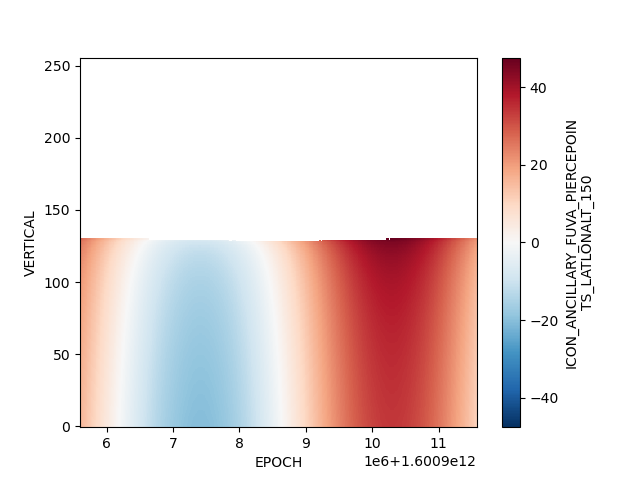

In [12]:
plt.figure()
lat.T.plot()

In [15]:
# Take representative example
i = 225

ds0 = ds.isel(EPOCH=i, HORIZONTAL=3) # first orbit, middle stripe
lla = ds0.ICON_ANCILLARY_FUVA_PIERCEPOINTS_LATLONALT_150
lat = lla.isel(VECTORS=0)
lon = lla.isel(VECTORS=1)
alt = lla.isel(VECTORS=2)
sc_xyz = ds0.ICON_ANCILLARY_FUV_SC_POSITION_ECEF

xyz = np.array([wgs84_to_ecef(lla.isel(VERTICAL=j)) for j in range(ds0.dims['VERTICAL'])])



In [16]:
dxyz = xyz - sc_xyz.values

d = np.sqrt((dxyz**2).sum(axis=1))

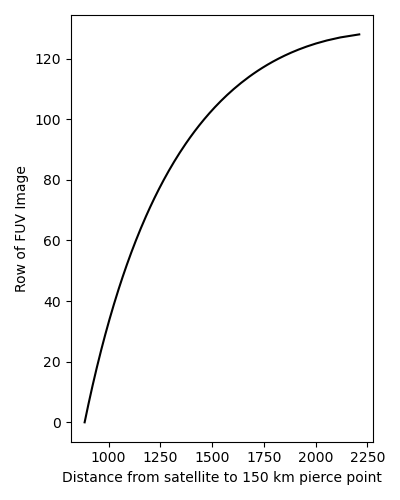

In [17]:
plt.figure(figsize=(4,5))
plt.plot(d, np.arange(len(d)),  'k-')
plt.ylabel('Row of FUV Image')
plt.xlabel('Distance from satellite to 150 km pierce point')
plt.tight_layout()

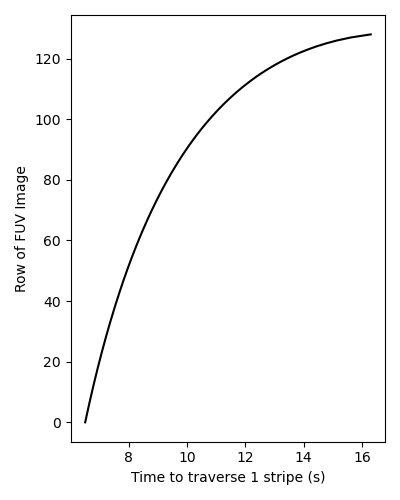

In [18]:
plt.figure(figsize=(4,5))
plt.plot(d*np.sin(3*np.pi/180)/7.1, np.arange(len(d)),  'k-')
plt.ylabel('Row of FUV Image')
plt.xlabel('Time to traverse 1 stripe (s)')
plt.tight_layout()

<xarray.DataArray 'ICON_ANCILLARY_FUV_SC_POSITION_ECEF' (VECTORS: 3)>
array([5150.3794, 3509.9783, 3136.168 ], dtype=float32)
Coordinates:
    EPOCH    float64 1.578e+12
Dimensions without coordinates: VECTORS
Attributes: (12/14)
    CatDesc:       Spacecraft Position in ECEF Coordinates
    Depend_0:      EPOCH
    Depend_1:      VECTORS
    Display_Type:  time_series
    FieldNam:      Earth Centered Earth Fixed s/c Position
    FillVal:       0.0
    ...            ...
    ValidMax:      10000.0
    Valid_Max:     10000.0
    ValidMin:      -10000.0
    Valid_Min:     -10000.0
    Var_Notes:     Position of spacecraft in ECEF cooridinates.
    Var_Type:      support_data